In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pickle
import time

In [2]:
# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.circuit import QuantumCircuit, Parameter
# from qiskit.tools.monitor import job_monitor
from qiskit.compiler import transpile
from qiskit.transpiler.passes import RemoveBarriers
from qiskit.quantum_info import state_fidelity

In [3]:
from osp_solutions.circuits import append_block_trotter_proposed, append_initial_state, append_block_trotter_negishi
from osp_solutions.simulator_dm import make_dm_binary, hamiltonian_to_dm, DMExtended
from osp_solutions.hamiltonian import Hamiltonian, make_H_Heisenberg
from osp_solutions.backend_simulator import result_to_dms
from setting import *

In [4]:
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, pauli_error
# from qiskit_ibm_runtime.fake_provider import FakeJakartaV2
# backend = AerSimulator.from_backend(FakeJakartaV2())
# backend = Aer.get_backend("qasm_simulator")
###? p_dep1 = 1.0 * 1e-4
error_dep1 = pauli_error([("I", 1 - 3 * p_dep1 / 4), ("X", p_dep1 / 4), ("Y", p_dep1 / 4), ("Z", p_dep1 / 4)])
# error_dep2_local = error_dep1.tensor(error_dep1)

###? p_dep2 = 1.0 * 1e-3
error_dep2_global = pauli_error([("II", 1 - 15 * p_dep2 / 16), ("IX", p_dep2 / 16), ("IY", p_dep2 / 16), ("IZ", p_dep2 / 16),
                                 ("XI", p_dep2 / 16), ("XX", p_dep2 / 16), ("XY", p_dep2 / 16), ("XZ", p_dep2 / 16),
                                 ("YI", p_dep2 / 16), ("YX", p_dep2 / 16), ("YY", p_dep2 / 16), ("YZ", p_dep2 / 16),
                                 ("ZI", p_dep2 / 16), ("ZX", p_dep2 / 16), ("ZY", p_dep2 / 16), ("ZZ", p_dep2 / 16)])

# print(error_dep2_global)

# Add errors to noise model
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error_dep1, ["rx", "rz", "sx", "h", "sdg", "s", "x", "u1", "u2", "u3"])
noise_model.add_all_qubit_quantum_error(error_dep2_global, ["cz"])
# noise_model.add_all_qubit_quantum_error(error_3, ["cswap", "ccx"])
print(noise_model)
print()

# Create noisy simulator backend
simulator_noisy = AerSimulator(method="density_matrix",
                               noise_model=noise_model)
simulator_ideal = AerSimulator(method="density_matrix")

NoiseModel: Ideal



In [6]:
###? num_qubits = 5

# The final time of the state evolution
###? time_evolution = np.pi

# Parameterize variable t to be evaluated at t=pi later
dt = Parameter('t')

# initial layout
# initial_layout = [5,3,1]
###? initial_layout = list(range(num_qubits))

# Number of trotter steps
# num_steps_list = [4,10,50,100,200] # ,20,30,40,50] # ,60,70,80,90,100]
###? num_steps_list = list(range(4,100,4))
print("trotter step list: ", num_steps_list)

###? lmd = 1.0

###? state_initial_str = "10101" ### specify initial state
state_initial_dm = DMExtended(matrix=make_dm_binary(str_binary=state_initial_str, 
                                                    endian_binary="little_endian", 
                                                    endian_dm="big_endian")) ### make the density matrix for the initial state

H_Heisenberg = make_H_Heisenberg(num_qubits=num_qubits) ### create Heisenberg Hamiltonian in a dictionary format
matrix_Heisenberg = hamiltonian_to_dm(hamiltonian=H_Heisenberg) ### convert Heisenberg Hamiltonian to its matrix form

U_Heisenberg = DMExtended(sp.linalg.expm(-1.0j * matrix_Heisenberg * time_evolution)) ### prepare the unitary matrix of the Heisenberg Hamiltonian

state_target_dm = state_initial_dm.apply_unitary(U_Heisenberg) ### apply the unitary evolution to the density matrix
state_target_dm.is_valid()

trotter step list:  [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96]


True

In [ ]:
fidelities = []

for time_evolution in times_evolution_discrete:
    
    print("trotter steps: ", num_steps)
    t1 = time.perf_counter()
    
    # Initialize quantum circuit for 3 qubits
    qc = QuantumCircuit(num_qubits)

    # Prepare initial state
    append_initial_state(qc=qc, 
                         state_initial_str=state_initial_str)
    append_block_trotter_proposed(qc=qc, 
                                  dt=dt,  ###!
                                  lmd= lmd, ### !
                                  num_steps=num_steps, ###!
                                 )

    # Evaluate simulation at target_time (t=pi) meaning each trotter step evolves pi/trotter_steps in time
    qc = qc.assign_parameters({dt: time_evolution / num_steps})
    qc_t3 = transpile(RemoveBarriers()(qc), optimization_level=3, basis_gates=["sx", "cx", "rz"])
    qc_t3.save_density_matrix()
    
    ### execute circuits
    result_raw = simulator_noisy.run(qc_t3,
                                     shots=0,
                                    ).result()
    dm_raw = result_to_dms(result=result_raw,
                        endian_dm="big")[0]

    fidelities.append(state_fidelity(dm_raw, state_target_dm))
    
    t2 = time.perf_counter()
    print('raw state tomography fidelity = {:.4f} \u00B1 {:.4f}'.format(np.mean(fidelities), np.std(fidelities)))
    print("number of CNOT gates:", qc_t3.count_ops().get("cx"))
    print("time:", t2 - t1)
    print()

trotter steps:  4
raw state tomography fidelity = 0.0150 ± 0.0000
number of CNOT gates: None
time: 0.4015725830104202

trotter steps:  8
raw state tomography fidelity = 0.0116 ± 0.0034
number of CNOT gates: 112
time: 0.5921392089221627

trotter steps:  12
raw state tomography fidelity = 0.0159 ± 0.0067
number of CNOT gates: 168
time: 0.5857439580140635

trotter steps:  16
raw state tomography fidelity = 0.0704 ± 0.0945
number of CNOT gates: 224
time: 0.6310939169488847

trotter steps:  20
raw state tomography fidelity = 0.1606 ± 0.1992
number of CNOT gates: 280
time: 0.7061514580855146

trotter steps:  24
raw state tomography fidelity = 0.2509 ± 0.2718
number of CNOT gates: 336
time: 0.9514268749626353

trotter steps:  28
raw state tomography fidelity = 0.3298 ± 0.3173
number of CNOT gates: 392
time: 0.8857988340314478

trotter steps:  32
raw state tomography fidelity = 0.3964 ± 0.3451
number of CNOT gates: 448
time: 0.9254810409620404

trotter steps:  36
raw state tomography fidelity 

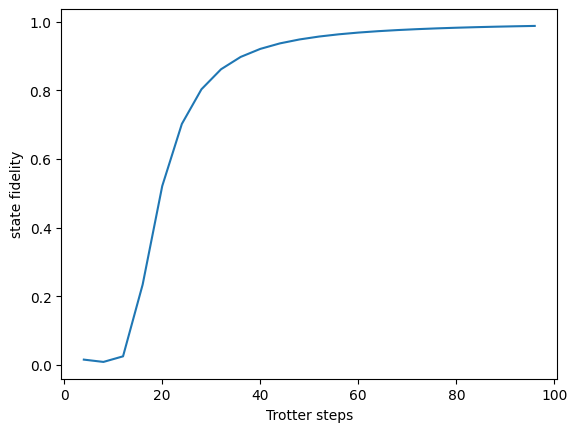

In [ ]:
plt.plot(times_evolution_discrete, fidelities)
plt.xlabel("Trotter steps")
plt.ylabel("state fidelity")
plt.show()

In [ ]:
with open("run_proposed.pkl", "wb") as f:
    pickle.dump({"fidelities": fidelities}, f)

In [12]:
print(simulator_noisy)

AerSimulator('aer_simulator_density_matrix')
